<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/PDCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dataset
# Reference PD by aging
refPD = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/extrapolateByRisk.csv')

# Average by segment
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/averageExtrapolate.csv')
df = df.set_index(['Segment', 'N']) #Set index to avoid un-used columns
df

,,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
Segment,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CU,1691326,0.006885,0.010671,0.014351,0.018028,0.021711,0.025393,0.029059,0.032694,0.036283,0.039815,0.043278,0.046662,0.049961,0.053167,0.056277,0.059287,0.062193,0.064996,0.067693,0.070285,0.072772,0.075156,0.077438,0.079619,0.081702,0.083689,0.085583,0.087387,0.089103,0.090734,0.092284,0.093755,0.095150,0.096473,0.097727,0.098914,0.100037,0.101099,0.102103,0.103052,...,0.117979,0.11798,0.117981,0.117982,0.117983,0.117984,0.117984,0.117985,0.117986,0.117986,0.117987,0.117987,0.117988,0.117988,0.117988,0.117989,0.117989,0.117989,0.117990,0.117990,0.117990,0.117991,0.117991,0.117991,0.117991,0.117991,0.117992,0.117992,0.117992,0.117992,0.117992,0.117992,0.117992,0.117992,0.117992,0.117993,0.117993,0.117993,0.117993,0.117993
HU,4850739,0.004516,0.007045,0.009512,0.011978,0.014450,0.016922,0.019386,0.021832,0.024250,0.026635,0.028978,0.031275,0.033520,0.035710,0.037841,0.039912,0.041919,0.043864,0.045743,0.047557,0.049307,0.050992,0.052613,0.054171,0.055667,0.057102,0.058478,0.059795,0.061055,0.062261,0.063413,0.064513,0.065564,0.066566,0.067521,0.068431,0.069298,0.070124,0.070909,0.071656,...,0.084908,0.08491,0.084911,0.084913,0.084914,0.084916,0.084917,0.084918,0.084919,0.084921,0.084922,0.084922,0.084923,0.084924,0.084925,0.084926,0.084926,0.084927,0.084928,0.084928,0.084929,0.084929,0.084930,0.084930,0.084930,0.084931,0.084931,0.084931,0.084932,0.084932,0.084932,0.084933,0.084933,0.084933,0.084933,0.084934,0.084934,0.084934,0.084934,0.084934


In [3]:
# 12-Month PD from transaction data
ODR = {
    'Segment': ['CU', 'CU', 'CU', 'CU', 'HU', 'HU', 'HU', 'HU'],
    'Aging': [0, 1, 2, 3, 0, 1, 2, 3],
    'N': [1425717, 178034, 73212, 14363, 4232680, 423105, 164827, 30127],
    'Bad': [24689, 23044, 21677, 10429, 47504, 41338, 43319, 20930]
}

ODR = pd.DataFrame(ODR)
ODR = ODR.eval('ODR = Bad / N')
ODR

,Segment,Aging,N,Bad,ODR
0,CU,0,1425717,24689,0.017317
1,CU,1,178034,23044,0.129436
2,CU,2,73212,21677,0.296085
3,CU,3,14363,10429,0.726102
4,HU,0,4232680,47504,0.011223
5,HU,1,423105,41338,0.097702
6,HU,2,164827,43319,0.262815
7,HU,3,30127,20930,0.694726


# Central Tendency (CT)
### Given the relevance of final PDs in reflecting the economic conditions this paper proposes a modern structured calibration approach using Bayesian techniques for the estimation of average long run historical default rate (so called Central Tendency, CT).
---
PD Calibrated = $\frac{PD_{bucket}\frac{PD_{ttc}}{PD_{target}}}{PD_{bucket}\frac{PD_{ttc}}{PD_{target}} + (1-PD_{bucket})\frac{1-PD_{ttc}}{1-PD_{target}}}$
---



In [4]:
# Central Tendency (CT)
CTResults = None
for segment in df.index.get_level_values(0):
  ttc = df.loc[segment].values[0] #Get TTC Curve
  target = ttc[11] #12-Month TTC as target
  riskGrade = None
  for aging in ODR['Aging'].unique():
    bucket = ODR.query('Segment == @segment & Aging == @aging')['ODR'].values[0] #Get PD by risk grade
    calibrated = None
    for i in range(ttc.shape[0]):
      carlibration = (bucket * (ttc[i] / target)) / ((bucket * (ttc[i] / target)) + (((1 - ttc[i]) / (1 - target)) * (1 - bucket)))
      if calibrated is None:
        calibrated = carlibration.copy()
      else:
        calibrated = np.column_stack((calibrated, carlibration))
    if riskGrade is None:
      riskGrade = calibrated.copy()
    else:
      riskGrade = np.vstack((riskGrade, calibrated))
  if CTResults is None:
    CTResults = riskGrade.copy()
  else:
    CTResults = np.vstack((CTResults, riskGrade))

In [5]:
# Define function for table summary
def summaryResult(data, method):
  result = pd.DataFrame(data)
  result.columns = [x for x in range(1, df.shape[1] + 1)]
  result = result.set_index(ODR.set_index(['Segment', 'Aging', 'N']).index)
  result = result.reset_index()
  result.to_csv(f'PDCalibration{method}.csv')

  averageResult = []
  for i in result.columns[3:]:
    selectData = result[['Segment', 'N', i]]
    average = selectData.groupby(['Segment']).apply(lambda x: np.average(x[i], weights = x['N']))
    average = average.rename(i)
    averageResult.append(average)
  averageResult = pd.concat(averageResult, axis = 1).reset_index()
  averageResult['N'] = list(result.groupby(['Segment'])['N'].sum()) #Get total number by segment
  cols = averageResult.columns
  cols = cols[0:1].append(cols[-1:]).append(cols[1:-1]) #Rearrange columns
  averageResult = averageResult[cols]
  averageResult.to_csv(f'averageCalibration{method}.csv', index = 0)
  return result, averageResult

In [6]:
# CT Summary table
CTResult, CTAverage = summaryResult(CTResults, 'CT')

In [7]:
# Show CT Result
CTResult

,Segment,Aging,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,CU,0,1425717,0.002490,0.003868,0.005215,0.006566,0.007927,0.009293,0.010660,0.012022,0.013374,0.014709,0.016025,0.017317,0.018581,0.019816,0.021019,0.022187,0.023320,0.024416,0.025475,0.026497,0.027480,0.028426,0.029334,0.030204,0.031038,0.031836,0.032598,0.033326,0.034020,0.034681,0.035310,0.035909,0.036478,0.037019,0.037532,0.038019,0.038480,...,0.045945,0.045946,0.045946,0.045946,0.045947,0.045947,0.045947,0.045948,0.045948,0.045948,0.045948,0.045949,0.045949,0.045949,0.045949,0.045949,0.045949,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045950,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951,0.045951
1,CU,1,178034,0.020625,0.031724,0.042356,0.052821,0.063156,0.073340,0.083336,0.093109,0.102629,0.111868,0.120809,0.129436,0.137740,0.145717,0.153364,0.160681,0.167673,0.174345,0.180703,0.186755,0.192511,0.197979,0.203170,0.208094,0.212761,0.217182,0.221368,0.225328,0.229072,0.232612,0.235956,0.239114,0.242095,0.244909,0.247562,0.250064,0.252423,...,0.288923,0.288925,0.288926,0.288928,0.288930,0.288931,0.288933,0.288934,0.288935,0.288936,0.288937,0.288938,0.288939,0.288940,0.288941,0.288942,0.288942,0.288943,0.288944,0.288944,0.288945,0.288945,0.288945,0.288946,0.288946,0.288947,0.288947,0.288947,0.288948,0.288948,0.288948,0.288948,0.288949,0.288949,0.288949,0.288949,0.288949,0.288949,0.288950,0.288950
2,CU,2,73212,0.056228,0.084827,0.111212,0.136269,0.160171,0.182943,0.204580,0.225080,0.244455,0.262725,0.279922,0.296085,0.311259,0.325491,0.338830,0.351324,0.363024,0.373976,0.384227,0.393819,0.402795,0.411195,0.419056,0.426412,0.433296,0.439740,0.445772,0.451419,0.456706,0.461657,0.466293,0.470635,0.474702,0.478511,0.482080,0.485423,0.488556,...,0.534775,0.534777,0.534779,0.534781,0.534783,0.534785,0.534787,0.534788,0.534790,0.534791,0.534793,0.534794,0.534795,0.534796,0.534797,0.534798,0.534798,0.534799,0.534800,0.534801,0.534801,0.534802,0.534802,0.534803,0.534803,0.534804,0.534804,0.534804,0.534805,0.534805,0.534805,0.534806,0.534806,0.534806,0.534806,0.534807,0.534807,0.534807,0.534807,0.534807
3,CU,3,14363,0.272984,0.368756,0.440908,0.498578,0.545867,0.585260,0.618463,0.646717,0.670961,0.691915,0.710146,0.726102,0.740141,0.752556,0.763584,0.773419,0.782225,0.790136,0.797266,0.803712,0.809554,0.814862,0.819696,0.824109,0.828144,0.831840,0.835232,0.838350,0.841220,0.843865,0.846305,0.848559,0.850644,0.852574,0.854362,0.856020,0.857559,...,0.878710,0.878711,0.878712,0.878712,0.878713,0.878714,0.878715,0.878715,0.878716,0.878717,0.878717,0.878718,0.878718,0.878719,0.878719,0.878719,0.878720,0.878720,0.878720,0.878721,0.878721,0.878721,0.878721,0.878722,0.878722,0.878722,0.878722,0.878722,0.878722,0.878723,0.878723,0.878723,0.878723,0.878723,0.878723,0.878723,0.878723,0.878723,0.878724,0.878724
4,HU,0,4232680,0.001592,0.002488,0.003365,0.004244,0.005128,0.006016,0.006902,0.007786,0.008662,0.009529,0.010383,0.011223,0.012047,0.012852,0.013639,0.014405,0.015150,0.015873,0.016574,0.017252,0.017908,0.018541,0.019151,0.019739,0.020304,0.020848,0.021370,0.021870,0.022351,0.022810,0.023251,0.023672,0.024074,0.024459,0.024826,0.025176,0.025510,...,0.031591,0.031592,0.031592,0.031593,0.031593,0.031594,0.031595,0.031595,0.031595,0.031596,0.031596,0.031597,0.031597,0.031597,0.031598,0.031598,0.031598,0.031598,0.031599,0.031599,0.031599,0.031599,0.031599,0.031600,0.031600,0.031600,0.031600,0.031600,0.031600,0.031600,0.031601,0.031601,0.031601,0.031601,0.031601,0.031601,0.031601,0.031601,0.031601,0.031601
5,HU,1,423105,0.014987,0.023243,0.031203,0.039072,0.046870,0.054582,0.062182,0.069643,0.076942,0.084061,0.090985,0.097702,0.104202,0.110482,0.116536,0.122365,0.12

In [8]:
# Show CT Average
CTAverage

,Segment,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,CU,1691326,0.009022,0.013404,0.017413,0.021228,0.024899,0.028443,0.031866,0.035170,0.038356,0.041423,0.044373,0.047205,0.049921,0.052523,0.055013,0.057392,0.059664,0.061832,0.063898,0.065866,0.067739,0.069521,0.071214,0.072822,0.074348,0.075796,0.077169,0.078471,0.079703,0.080870,0.081974,0.083018,0.084006,0.084939,0.085820,0.086653,0.087438,0.088180,...,0.099754,0.099754,0.099755,0.099755,0.099756,0.099757,0.099757,0.099757,0.099758,0.099758,0.099759,0.099759,0.099759,0.099760,0.099760,0.099760,0.099760,0.099761,0.099761,0.099761,0.099761,0.099761,0.099761,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099762,0.099763,0.099763,0.099763,0.099763,0.099763,0.099763
1,HU,4850739,0.005823,0.008738,0.011423,0.013985,0.016455,0.018842,0.021151,0.023384,0.025541,0.027622,0.029628,0.031560,0.033419,0.035205,0.036919,0.038564,0.040141,0.041651,0.043097,0.044480,0.045801,0.047064,0.048271,0.049422,0.050520,0.051566,0.052564,0.053515,0.054420,0.055282,0.056102,0.056881,0.057623,0.058328,0.058998,0.059634,0.060238,0.060812,...,0.070851,0.070852,0.070854,0.070855,0.070856,0.070856,0.070857,0.070858,0.070859,0.070860,0.070860,0.070861,0.070861,0.070862,0.070862,0.070863,0.070863,0.070864,0.070864,0.070865,0.070865,0.070865,0.070866,0.070866,0.070866,0.070866,0.070867,0.070867,0.070867,0.070867,0.070867,0.070868,0.070868,0.070868,0.070868,0.070868,0.070868,0.070868,0.070869,0.070869


# PD Scalar
### The term 'variable scalar' is used to describe approaches in which the outputs of an underlying, relatively PiT, rating system are transformed to produce final PD estimates used for regulatory capital requirements that are relatively non-cyclical. Typically, this involves basing the resulting requirement on the long run default rate of the portfolio or its segments.
---
PD Scalar = $\frac{PD_{unbias}}{Cumulative PD_{i}}$
---



In [9]:
# PD Scalar
ScalarResults = None
for segment, _ in enumerate(ODR['Aging']):
  ttc = refPD.set_index(['Segment', 'Aging', 'N']).iloc[segment].values #Get TTC Curve
  bucket = ODR.iloc[segment]['ODR'] #Get PD by risk grade
  calibrated = None
  for i in range(ttc.shape[0]):
    if calibrated is None:
      calibrated = ttc[10 - i] * (bucket / ttc[11 - i]) #Scalar for less than 12-Month
    elif calibrated is not None and i == 1:
      carlibration = ttc[10 - i] * (calibrated / ttc[11 - i])
      calibrated = np.column_stack((carlibration, calibrated)) #Create 2-D Array for keeping result
    elif calibrated is not None and i < 11:
      carlibration = ttc[10 - i] * (calibrated[0][0] / ttc[11 - i])
      calibrated = np.column_stack((carlibration, calibrated)) #Keep PD month less than equal 12-Month
    elif calibrated is not None and i == 11:
      calibrated = np.column_stack((calibrated, bucket)) #Replace with 12-Month PD
    else:
      carlibration = ttc[i] * (calibrated[0][-1] / ttc[i - 1]) #PD Scalar
      calibrated = np.column_stack((calibrated, carlibration))
  if ScalarResults is None:
    ScalarResults = calibrated.copy()
  else:
    ScalarResults = np.vstack((ScalarResults, calibrated))

In [10]:
# Scalar summary table
ScalarResult, ScalarAverage = summaryResult(ScalarResults, 'Scalar')

In [11]:
# Show scalar result
ScalarResult

,Segment,Aging,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,CU,0,1425717,0.000180,0.000712,0.001561,0.002684,0.004039,0.005591,0.007304,0.009147,0.011093,0.013117,0.015198,0.017317,0.019456,0.021602,0.023742,0.025864,0.027960,0.030023,0.032045,0.034021,0.035947,0.037819,0.039634,0.041392,0.043089,0.044726,0.046302,0.047816,0.049270,0.050664,0.051998,0.053275,0.054494,0.055657,0.056767,0.057823,0.058829,...,0.075836,0.075837,0.075838,0.075839,0.075840,0.075841,0.075841,0.075842,0.075843,0.075843,0.075844,0.075844,0.075845,0.075845,0.075846,0.075846,0.075847,0.075847,0.075847,0.075848,0.075848,0.075848,0.075848,0.075848,0.075849,0.075849,0.075849,0.075849,0.075849,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850
1,CU,1,178034,0.007415,0.017952,0.029565,0.041594,0.053692,0.065647,0.077326,0.088641,0.099537,0.109979,0.119948,0.129436,0.138442,0.146973,0.155038,0.162650,0.169825,0.176579,0.182929,0.188895,0.194493,0.199743,0.204662,0.209268,0.213579,0.217611,0.221380,0.224901,0.228190,0.231261,0.234126,0.236798,0.239291,0.241614,0.243779,0.245796,0.247675,...,0.272357,0.272358,0.272359,0.272359,0.272360,0.272360,0.272361,0.272361,0.272361,0.272362,0.272362,0.272362,0.272363,0.272363,0.272363,0.272363,0.272363,0.272364,0.272364,0.272364,0.272364,0.272364,0.272364,0.272364,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365
2,CU,2,73212,0.052034,0.089349,0.121127,0.149098,0.174102,0.196659,0.217133,0.235794,0.252858,0.268500,0.282867,0.296085,0.308262,0.319493,0.329860,0.339440,0.348297,0.356493,0.364080,0.371108,0.377621,0.383659,0.389259,0.394455,0.399276,0.403753,0.407909,0.411770,0.415357,0.418691,0.421789,0.424669,0.427346,0.429837,0.432153,0.434307,0.436312,...,0.463547,0.463549,0.463550,0.463551,0.463552,0.463553,0.463554,0.463555,0.463556,0.463557,0.463558,0.463558,0.463559,0.463559,0.463560,0.463561,0.463561,0.463561,0.463562,0.463562,0.463563,0.463563,0.463563,0.463564,0.463564,0.463564,0.463564,0.463565,0.463565,0.463565,0.463565,0.463565,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566
3,CU,3,14363,0.440118,0.516854,0.565131,0.600200,0.627433,0.649423,0.667640,0.683008,0.696152,0.707512,0.717413,0.726102,0.733771,0.740573,0.746631,0.752045,0.756900,0.761264,0.765198,0.768752,0.771968,0.774884,0.777533,0.779942,0.782135,0.784136,0.785963,0.787632,0.789160,0.790558,0.791840,0.793016,0.794095,0.795086,0.795997,0.796836,0.797607,...,0.807101,0.807101,0.807101,0.807102,0.807102,0.807102,0.807103,0.807103,0.807103,0.807103,0.807104,0.807104,0.807104,0.807104,0.807104,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106
4,HU,0,4232680,0.000140,0.000521,0.001102,0.001852,0.002742,0.003748,0.004851,0.006030,0.007270,0.008557,0.009879,0.011223,0.012581,0.013945,0.015307,0.016661,0.018001,0.019324,0.020624,0.021900,0.023148,0.024366,0.025552,0.026706,0.027825,0.028910,0.029959,0.030973,0.031951,0.032894,0.033801,0.034674,0.035513,0.036318,0.037090,0.037830,0.038538,...,0.052034,0.052036,0.052038,0.052039,0.052041,0.052042,0.052043,0.052044,0.052045,0.052046,0.052047,0.052048,0.052049,0.052050,0.052050,0.052051,0.052052,0.052052,0.052053,0.052053,0.052054,0.052054,0.052055,0.052055,0.052056,0.052056,0.052056,0.052057,0.052057,0.052057,0.052057,0.052058,0.052058,0.052058,0.052058,0.052059,0.052059,0.052059,0.052059,0.052059
5,HU,1,423105,0.005603,0.013375,0.021914,0.030781,0.039745,0.048664,0.057445,0.066027,0.074367,0.082437,0.090219,0.097702,0.104880,0.111752,0.118320,0.124588,0.13

In [12]:
# Show scalar result
ScalarAverage

,Segment,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,CU,1691326,0.006922,0.010747,0.014470,0.018191,0.021921,0.025651,0.029365,0.033048,0.036686,0.040265,0.043774,0.047205,0.050549,0.053799,0.056952,0.060003,0.062950,0.065791,0.068526,0.071154,0.073676,0.076093,0.078406,0.080618,0.082730,0.084745,0.086665,0.088494,0.090234,0.091888,0.093460,0.094951,0.096366,0.097708,0.098979,0.100182,0.101321,0.102399,...,0.119515,0.119516,0.119517,0.119518,0.119519,0.119520,0.119520,0.119521,0.119522,0.119522,0.119523,0.119523,0.119524,0.119524,0.119525,0.119525,0.119525,0.119526,0.119526,0.119526,0.119527,0.119527,0.119527,0.119527,0.119527,0.119528,0.119528,0.119528,0.119528,0.119528,0.119528,0.119528,0.119529,0.119529,0.119529,0.119529,0.119529,0.119529,0.119529,0.119529
1,HU,4850739,0.004536,0.007084,0.009573,0.012062,0.014558,0.017055,0.019544,0.022015,0.024460,0.026870,0.029239,0.031560,0.033830,0.036044,0.038199,0.040292,0.042323,0.044289,0.046189,0.048024,0.049794,0.051498,0.053137,0.054713,0.056226,0.057678,0.059069,0.060401,0.061676,0.062896,0.064061,0.065174,0.066237,0.067250,0.068216,0.069137,0.070014,0.070849,...,0.085807,0.085808,0.085810,0.085812,0.085813,0.085815,0.085816,0.085817,0.085818,0.085819,0.085820,0.085821,0.085822,0.085823,0.085824,0.085824,0.085825,0.085826,0.085826,0.085827,0.085827,0.085828,0.085828,0.085829,0.085829,0.085830,0.085830,0.085830,0.085831,0.085831,0.085831,0.085831,0.085832,0.085832,0.085832,0.085832,0.085833,0.085833,0.085833,0.085833


In [13]:
# Simplify version
scalar = ODR.copy()
scalar['PDTarget'] = list(refPD['12'])
scalar = scalar.eval('scalar = ODR / PDTarget')
scalar = scalar['scalar']

# Multiply dataframe (Only show result)
refPD.drop(['Segment', 'Aging', 'N'], axis = 1).mul(scalar, axis = 0).set_index(ODR.set_index(['Segment', 'Aging', 'N']).index).reset_index()

,Segment,Aging,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,CU,0,1425717,0.000180,0.000712,0.001561,0.002684,0.004039,0.005591,0.007304,0.009147,0.011093,0.013117,0.015198,0.017317,0.019456,0.021602,0.023742,0.025864,0.027960,0.030023,0.032045,0.034021,0.035947,0.037819,0.039634,0.041392,0.043089,0.044726,0.046302,0.047816,0.049270,0.050664,0.051998,0.053275,0.054494,0.055657,0.056767,0.057823,0.058829,...,0.075836,0.075837,0.075838,0.075839,0.075840,0.075841,0.075841,0.075842,0.075843,0.075843,0.075844,0.075844,0.075845,0.075845,0.075846,0.075846,0.075847,0.075847,0.075847,0.075848,0.075848,0.075848,0.075848,0.075848,0.075849,0.075849,0.075849,0.075849,0.075849,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850,0.075850
1,CU,1,178034,0.007415,0.017952,0.029565,0.041594,0.053692,0.065647,0.077326,0.088641,0.099537,0.109979,0.119948,0.129436,0.138442,0.146973,0.155038,0.162650,0.169825,0.176579,0.182929,0.188895,0.194493,0.199743,0.204662,0.209268,0.213579,0.217611,0.221380,0.224901,0.228190,0.231261,0.234126,0.236798,0.239291,0.241614,0.243779,0.245796,0.247675,...,0.272357,0.272358,0.272359,0.272359,0.272360,0.272360,0.272361,0.272361,0.272361,0.272362,0.272362,0.272362,0.272363,0.272363,0.272363,0.272363,0.272363,0.272364,0.272364,0.272364,0.272364,0.272364,0.272364,0.272364,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365,0.272365
2,CU,2,73212,0.052034,0.089349,0.121127,0.149098,0.174102,0.196659,0.217133,0.235794,0.252858,0.268500,0.282867,0.296085,0.308262,0.319493,0.329860,0.339440,0.348297,0.356493,0.364080,0.371108,0.377621,0.383659,0.389259,0.394455,0.399276,0.403753,0.407909,0.411770,0.415357,0.418691,0.421789,0.424669,0.427346,0.429837,0.432153,0.434307,0.436312,...,0.463547,0.463549,0.463550,0.463551,0.463552,0.463553,0.463554,0.463555,0.463556,0.463557,0.463558,0.463558,0.463559,0.463559,0.463560,0.463561,0.463561,0.463561,0.463562,0.463562,0.463563,0.463563,0.463563,0.463564,0.463564,0.463564,0.463564,0.463565,0.463565,0.463565,0.463565,0.463565,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566,0.463566
3,CU,3,14363,0.440118,0.516854,0.565131,0.600200,0.627433,0.649423,0.667640,0.683008,0.696152,0.707512,0.717413,0.726102,0.733771,0.740573,0.746631,0.752045,0.756900,0.761264,0.765198,0.768752,0.771968,0.774884,0.777533,0.779942,0.782135,0.784136,0.785963,0.787632,0.789160,0.790558,0.791840,0.793016,0.794095,0.795086,0.795997,0.796836,0.797607,...,0.807101,0.807101,0.807101,0.807102,0.807102,0.807102,0.807103,0.807103,0.807103,0.807103,0.807104,0.807104,0.807104,0.807104,0.807104,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807105,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106,0.807106
4,HU,0,4232680,0.000140,0.000521,0.001102,0.001852,0.002742,0.003748,0.004851,0.006030,0.007270,0.008557,0.009879,0.011223,0.012581,0.013945,0.015307,0.016661,0.018001,0.019324,0.020624,0.021900,0.023148,0.024366,0.025552,0.026706,0.027825,0.028910,0.029959,0.030973,0.031951,0.032894,0.033801,0.034674,0.035513,0.036318,0.037090,0.037830,0.038538,...,0.052034,0.052036,0.052038,0.052039,0.052041,0.052042,0.052043,0.052044,0.052045,0.052046,0.052047,0.052048,0.052049,0.052050,0.052050,0.052051,0.052052,0.052052,0.052053,0.052053,0.052054,0.052054,0.052055,0.052055,0.052056,0.052056,0.052056,0.052057,0.052057,0.052057,0.052057,0.052058,0.052058,0.052058,0.052058,0.052059,0.052059,0.052059,0.052059,0.052059
5,HU,1,423105,0.005603,0.013375,0.021914,0.030781,0.039745,0.048664,0.057445,0.066027,0.074367,0.082437,0.090219,0.097702,0.104880,0.111752,0.118320,0.124588,0.13

In [14]:
# Table combination
def combineTable(data1, data2, average = True):
  if average is True:
    data2 = data2.reset_index()
    idVars = 'Segment'
    sortValues = ['Segment', 'PDTypes', 'times']
  else:
    idVars = ['Segment', 'Aging']
    sortValues = ['Segment', 'Aging', 'PDTypes', 'times']
  data1, data2 = data1.drop(['N'], axis = 1), data2.drop(['N'], axis = 1)
  table1 = pd.melt(data1, id_vars = idVars, var_name = 'times', value_name = 'PD')
  table2 = pd.melt(data2, id_vars = idVars, var_name = 'times', value_name = 'PD')
  table2['times'] = table2['times'].astype(np.int16) #Change data type
  table1['PDTypes'], table2['PDTypes'] = 'calibratedPD', 'extrapolatedPD' #Key categorical
  table = pd.concat([table1, table2], axis = 0, ignore_index = True)
  table = table.sort_values(by = sortValues)
  return table

In [15]:
# Combined CT Average table
CTTable = combineTable(CTAverage, df, average = True)
CTTable.head(5)

,Segment,times,PD,PDTypes
0,CU,1,0.009022,calibratedPD
2,CU,2,0.013404,calibratedPD
4,CU,3,0.017413,calibratedPD
6,CU,4,0.021228,calibratedPD
8,CU,5,0.024899,calibratedPD


In [16]:
# Combined CT Risk grade table
CTGradeTable = combineTable(CTResult, refPD, average = False)
CTGradeTable.head(5)

,Segment,Aging,times,PD,PDTypes
0,CU,0,1,0.002490,calibratedPD
8,CU,0,2,0.003868,calibratedPD
16,CU,0,3,0.005215,calibratedPD
24,CU,0,4,0.006566,calibratedPD
32,CU,0,5,0.007927,calibratedPD


In [17]:
# Combined scalar average table
scalarTable = combineTable(ScalarAverage, df, average = True)
scalarTable.head(5)

,Segment,times,PD,PDTypes
0,CU,1,0.006922,calibratedPD
2,CU,2,0.010747,calibratedPD
4,CU,3,0.014470,calibratedPD
6,CU,4,0.018191,calibratedPD
8,CU,5,0.021921,calibratedPD


In [18]:
# Combined CT Risk grade table
scalarGradeTable = combineTable(ScalarResult, refPD, average = False)
scalarGradeTable.head(5)

,Segment,Aging,times,PD,PDTypes
0,CU,0,1,0.000180,calibratedPD
8,CU,0,2,0.000712,calibratedPD
16,CU,0,3,0.001561,calibratedPD
24,CU,0,4,0.002684,calibratedPD
32,CU,0,5,0.004039,calibratedPD


In [19]:
# Plot results
def plotPD(data, method, average = True):
  with plt.style.context('seaborn'):
    if average is True:
      plt.figure(figsize = (10, 6))
      plt.title(f'Comparison average PD: {method}')
      sns.lineplot(x = 'times', y = 'PD', data = data,
                   hue = 'Segment', style = 'PDTypes', legend = 'full',
                   palette = 'viridis', ci = None)
      plt.xlabel('Time')
      plt.ylabel('PD')
    else:
      fig, axs = plt.subplots(1, 2, figsize = (20, 6), sharey = True)
      fig.suptitle(f'Comparison calibrate PD: {method}')
      for i, segment in enumerate(data['Segment'].unique()):
        selectData = data.query('Segment == @segment')
        sns.lineplot(x = 'times', y = 'PD', data = selectData,
                     hue = 'Aging', style = 'PDTypes', legend = 'full',
                     palette = 'viridis', ci = None, ax = axs[i])
        axs[i].set_title(f'Segment {segment}')
        axs[i].set(xlabel = 'Time', ylabel = 'PD')
  return plt.show()

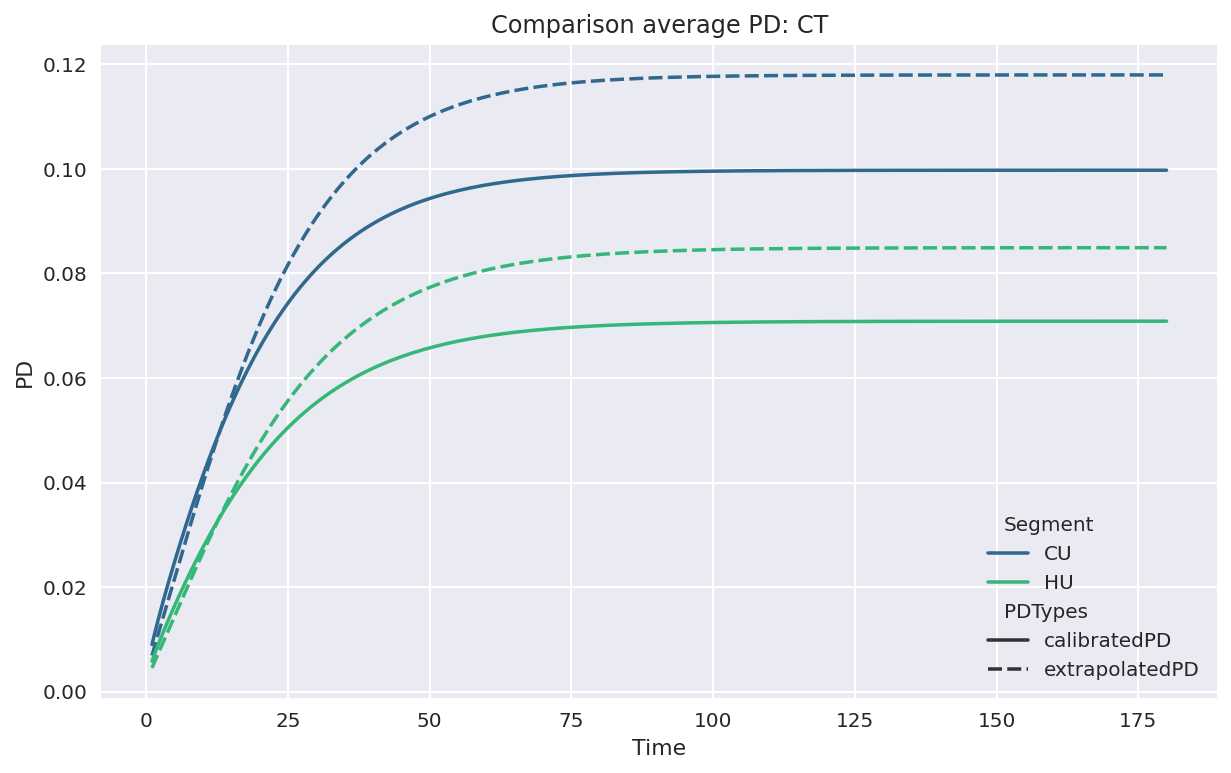

In [20]:
# Plot CT Compared average
plotPD(CTTable, 'CT', average = True)

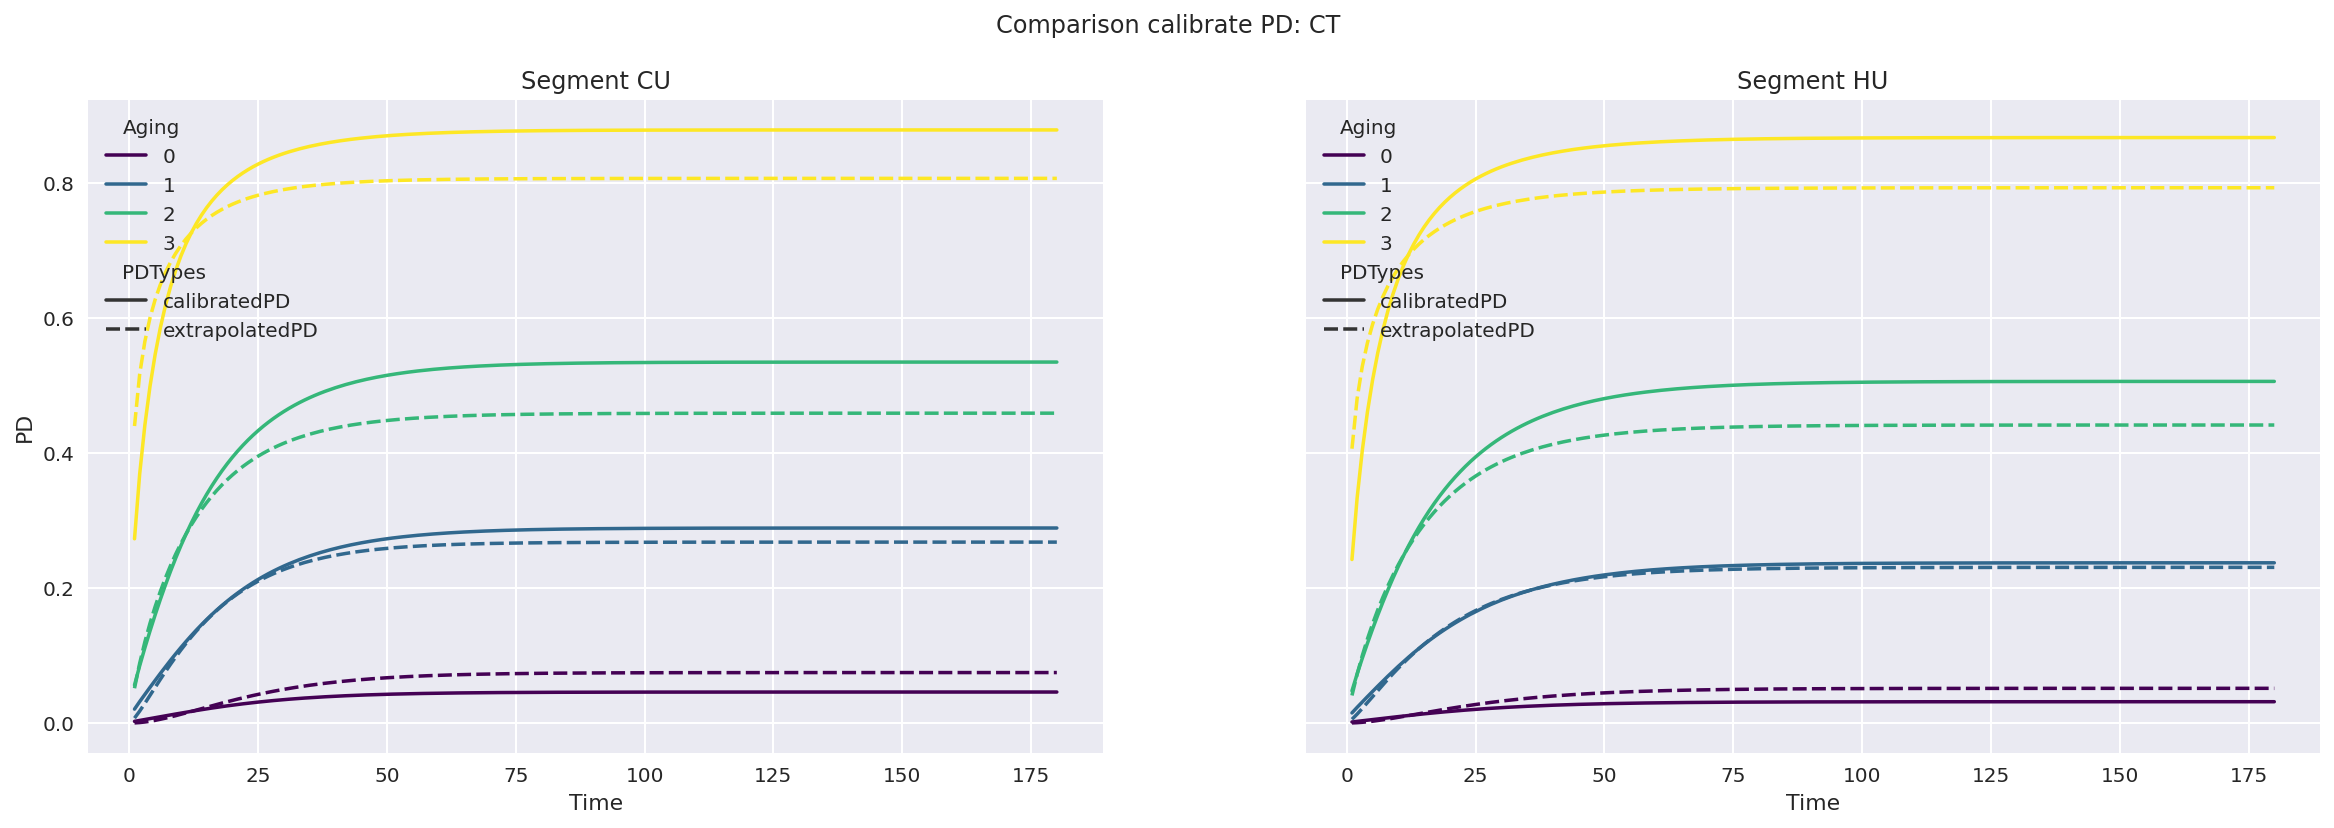

In [21]:
# Plot CT Compared calibrate
plotPD(CTGradeTable, 'CT', average = False)

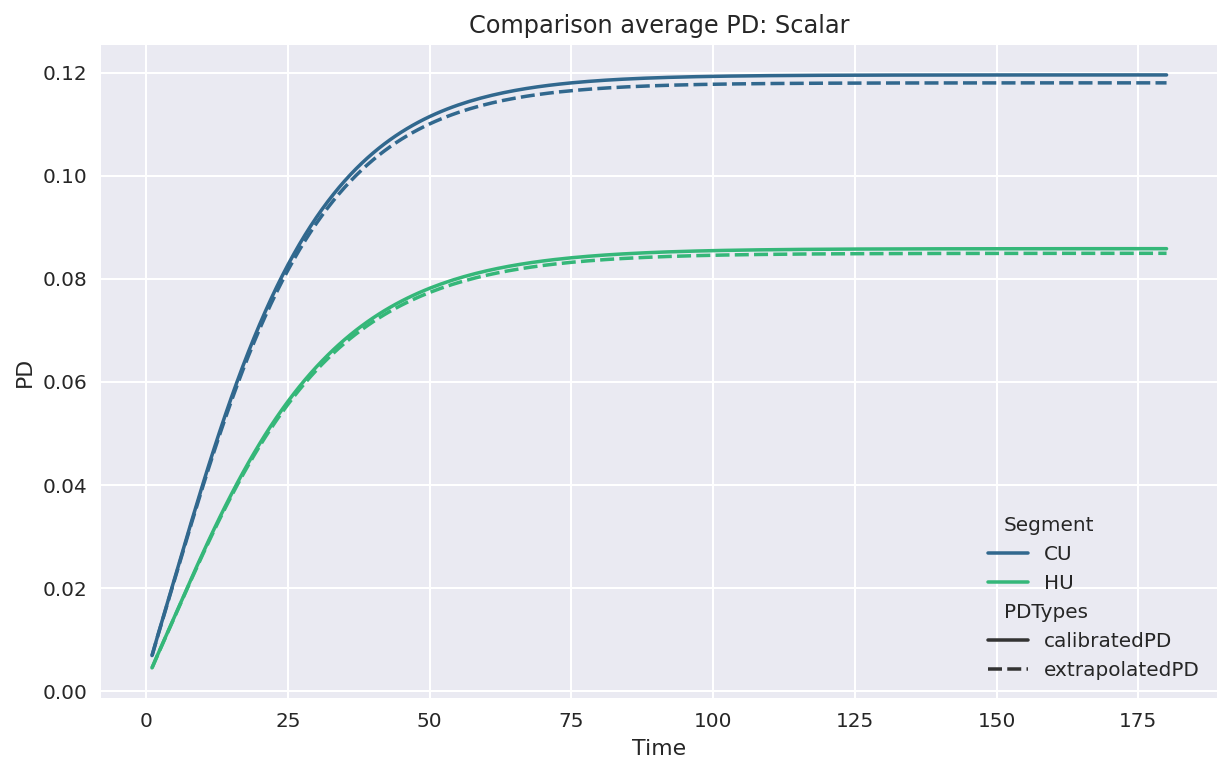

In [22]:
# Plot scalar compared average
plotPD(scalarTable, 'Scalar', average = True)

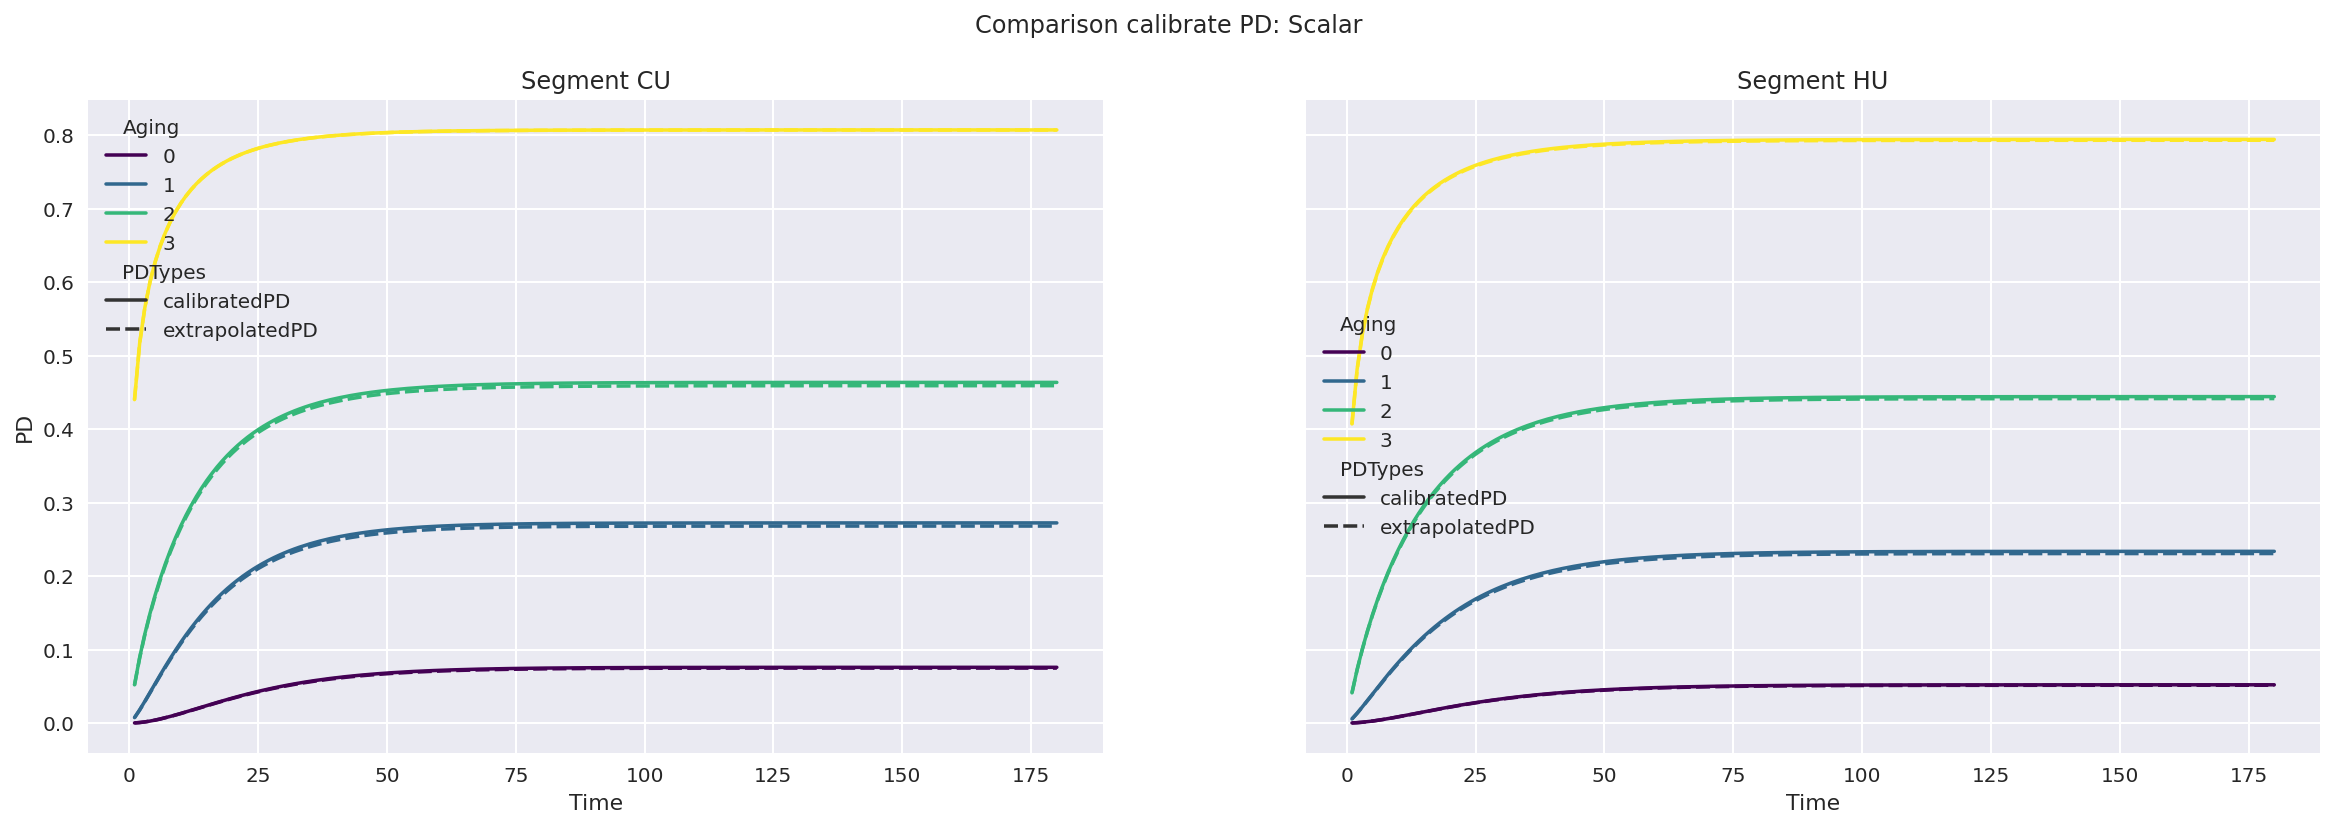

In [23]:
# Plot scalar compared calibrate
plotPD(scalarGradeTable, 'Scalar', average = False)